In [32]:
import sys; print(sys.executable)   # should point to ...\fraud-decisioning\.venv\python.exe


C:\Users\abhij\fraud-decisioning\.venv\Scripts\python.exe


In [33]:
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [34]:
#imports & paths
import os, numpy as np, pandas as pd, joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score
from xgboost import XGBClassifier
import shap
from pathlib import Path

ROOT = Path(r"C:\Users\abhij\fraud-decisioning")
DATA = ROOT/"data"/"transactions.csv"
ART  = ROOT/"model"/"artifacts"
ART.mkdir(parents=True, exist_ok=True)

# business costs (adjust if you want)
COST_FN, COST_FP = 20.0, 1.0

df = pd.read_csv(DATA)
y = df["is_fraud"].astype(int)
X = df.drop(columns=["is_fraud"])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn ≥1.4

pre = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", ohe, cat_cols),
])

xgb = XGBClassifier(
    n_estimators=600, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    objective="binary:logistic", eval_metric="aucpr", n_jobs=-1, random_state=42
)

pipe = Pipeline([("pre", pre), ("clf", xgb)]).fit(X_tr, y_tr)
proba = pipe.predict_proba(X_te)[:, 1]
roc = roc_auc_score(y_te, proba)
ap  = average_precision_score(y_te, proba)

# cost-optimal threshold
order = np.argsort(proba)[::-1]
y_sorted, p_sorted = y_te.values[order], proba[order]
tp = np.cumsum(y_sorted); fp = np.cumsum(1 - y_sorted)
pos = y_te.sum()
uniq = np.where(np.r_[True, p_sorted[1:] != p_sorted[:-1]])[0]
fn_u = pos - tp[uniq]
costs = COST_FN*fn_u + COST_FP*fp[uniq]
best_thr = float(p_sorted[uniq][costs.argmin()])

# save artifacts
joblib.dump(pipe, ART/"pipeline.pkl")
joblib.dump({"threshold":best_thr,"roc_auc":roc,"ap":ap,"cost_fn":COST_FN,"cost_fp":COST_FP}, ART/"metrics.pkl")

# optional SHAP (nice for plots)
explainer = shap.TreeExplainer(pipe.named_steps["clf"])
cat_names = list(pre.named_transformers_["cat"].get_feature_names_out(cat_cols)) if cat_cols else []
final_cols = num_cols + cat_names
joblib.dump({"explainer": explainer, "final_cols": final_cols}, ART/"shap.pkl")

print("Saved:", list(ART.glob('*')))
print(f"ROC AUC={roc:.4f}  PR-AUC={ap:.4f}  thr={best_thr:.4f}")


Saved: [WindowsPath('C:/Users/abhij/fraud-decisioning/model/artifacts/metrics.pkl'), WindowsPath('C:/Users/abhij/fraud-decisioning/model/artifacts/pipeline.pkl'), WindowsPath('C:/Users/abhij/fraud-decisioning/model/artifacts/shap.pkl')]
ROC AUC=0.7021  PR-AUC=0.8469  thr=0.0087


In [35]:
#load data & scores
df = pd.read_csv(DATA)
y  = df["is_fraud"].astype(int)
X  = df.drop(columns=["is_fraud"])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

proba = pipe.predict_proba(X_te)[:, 1]
roc   = roc_auc_score(y_te, proba)
ap    = average_precision_score(y_te, proba)

roc, ap, best_thr



(0.7021453341948074, 0.8468524212445816, 0.008682738989591599)

In [36]:
import joblib, pathlib

ROOT = pathlib.Path(r"C:\Users\abhij\fraud-decisioning")   # change if needed
ART  = ROOT / "model" / "artifacts"

# sanity check
print("Found:", list(ART.glob("*")))

pipe    = joblib.load(ART / "pipeline.pkl")     # model + preprocessor
metrics = joblib.load(ART / "metrics.pkl")      # dict with 'threshold', 'roc_auc', 'ap'
best_thr = float(metrics["threshold"])
print(metrics)


Found: [WindowsPath('C:/Users/abhij/fraud-decisioning/model/artifacts/metrics.pkl'), WindowsPath('C:/Users/abhij/fraud-decisioning/model/artifacts/pipeline.pkl'), WindowsPath('C:/Users/abhij/fraud-decisioning/model/artifacts/shap.pkl')]
{'threshold': 0.008682738989591599, 'roc_auc': 0.7021453341948074, 'ap': 0.8468524212445816, 'cost_fn': 20.0, 'cost_fp': 1.0}


'saved report/pr_curve.png'

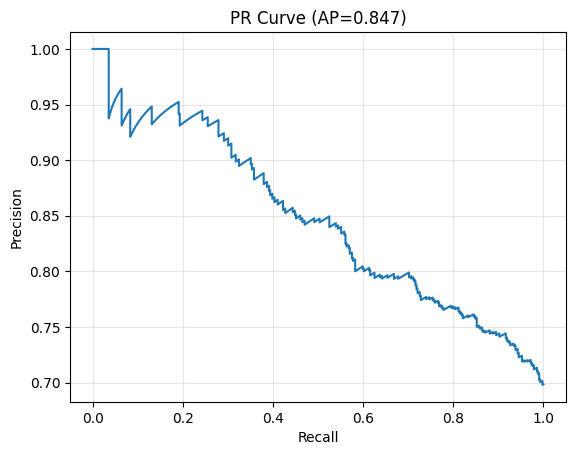

In [37]:
#PR curve
p, r, t = precision_recall_curve(y_te, proba)
plt.figure()
plt.plot(r, p)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR Curve (AP={ap:.3f})")
plt.grid(True, alpha=.3)
plt.savefig(f"{OUT}/pr_curve.png", dpi=180, bbox_inches="tight")
f"saved {OUT}/pr_curve.png"


'saved report/cost_curve.png'

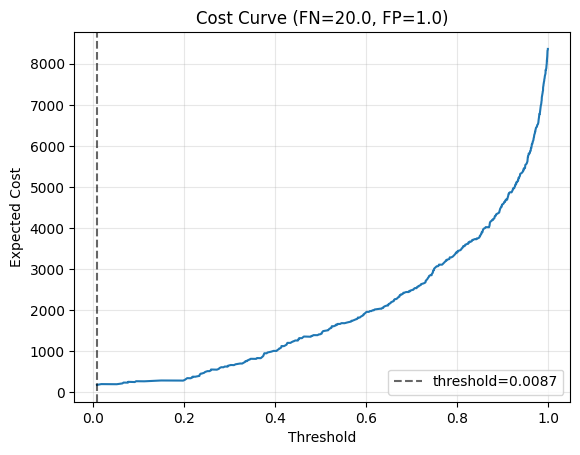

In [38]:
#Cost curve
order = np.argsort(proba)[::-1]
y_sorted = y_te.values[order]
p_sorted = proba[order]
tp = np.cumsum(y_sorted)
fp = np.cumsum(1 - y_sorted)
pos = y_te.sum()
uniq = np.where(np.r_[True, p_sorted[1:] != p_sorted[:-1]])[0]
tp_u, fp_u = tp[uniq], fp[uniq]
fn_u = pos - tp_u

COST_FN = float(metrics.get("cost_fn", 20.0))
COST_FP = float(metrics.get("cost_fp", 1.0))
costs = COST_FN*fn_u + COST_FP*fp_u
thr_u = p_sorted[uniq]

plt.figure()
plt.plot(thr_u, costs)
plt.axvline(best_thr, color="k", linestyle="--", alpha=.6, label=f"threshold={best_thr:.4f}")
plt.xlabel("Threshold"); plt.ylabel("Expected Cost")
plt.title(f"Cost Curve (FN={COST_FN}, FP={COST_FP})"); plt.legend()
plt.grid(True, alpha=.3)
plt.savefig(f"{OUT}/cost_curve.png", dpi=180, bbox_inches="tight")
f"saved {OUT}/cost_curve.png"


'saved report/shap_summary.png'

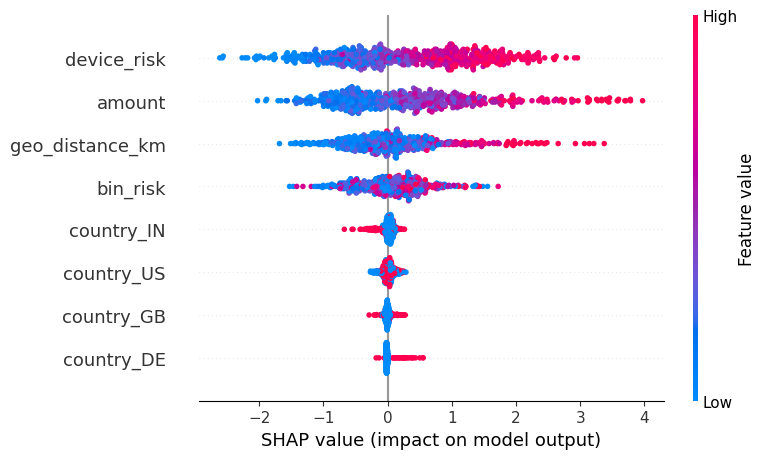

In [39]:
#SHAP summary
# transform to model input space
Xt = pipe.named_steps["pre"].transform(X_te)

if explainer is None:
    # fallback: rebuild TreeExplainer if not saved
    from xgboost import XGBClassifier
    explainer = shap.TreeExplainer(pipe.named_steps["clf"])

if final_cols is None:
    ohe = pipe.named_steps["pre"].named_transformers_.get("cat")
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
    cat_names = list(ohe.get_feature_names_out(cat_cols)) if cat_cols else []
    final_cols = num_cols + cat_names

shap_values = explainer.shap_values(Xt, check_additivity=False)
plt.figure()
shap.summary_plot(shap_values, Xt, feature_names=final_cols, show=False)
plt.savefig(f"{OUT}/shap_summary.png", dpi=180, bbox_inches="tight")
f"saved {OUT}/shap_summary.png"


In [40]:
#API call
import requests

API = "http://127.0.0.1:8000"   # change to 8010 if you used that
headers = {"x-api-key":"change-me", "Content-Type":"application/json"}
payload = {
    "amount": 129.5,
    "device_risk": 0.72,
    "geo_distance_km": 412.0,
    "bin_risk": 0.33,
    "country": "US"
}

r = requests.post(f"{API}/score", headers=headers, json=payload, timeout=5)
print(r.status_code, r.text)



200 {"fraud_proba":0.997123,"decision":1,"threshold":0.008682738989591599}


In [41]:
import requests

API = "http://127.0.0.1:8000"   # change to 8010 if you used that
headers = {"x-api-key":"change-me", "Content-Type":"application/json"}
payload = {
    "amount": 12.5,
    "device_risk": 0.05,
    "geo_distance_km": 1.3,
    "bin_risk": 0.02,
    "country": "US"
}
r = requests.post(f"{API}/score", headers=headers, json=payload, timeout=5)
print(r.status_code, r.text)


200 {"fraud_proba":0.188006,"decision":1,"threshold":0.008682738989591599}
